In [2]:
from pyiron_workflow_atomistics.bulk import eos_volume_scan, get_equil_lat_param, get_bulk_structure

from tensorpotential.calculator import TPCalculator

from ase.build import bulk

import numpy as np

from pyiron_workflow import Workflow
from pyiron_workflow_atomistics.calculator import calculate_structure_node
from pyiron_workflow_atomistics.gb.gb_code.constructor import construct_GB_from_GBCode

import pyiron_workflow as pwf
%load_ext autoreload
%autoreload 2

I0000 00:00:1749152925.595203   12559 service.cc:145] XLA service 0x57efa3216740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749152925.595301   12559 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2025-06-05 21:48:45.860758: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-05 21:48:46.234950: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1749152928.793276   12559 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/root/miniconda3/envs/pyiron_workflow/lib/python3.12/site-packages/pymatgen/core/structure.py:3106: BadPoscarWarning: Elements in POSCAR cannot be determined. Defaulting to false names ['H', 'H', 'H', 'H', 'H', 'H', 'He', 'He', 

0
      Step     Time          Energy          fmax
BFGS:    0 21:48:53     -295.775416        0.673971
BFGS:    1 21:48:53     -295.803325        0.530631
BFGS:    2 21:48:53     -295.863286        0.195338
BFGS:    3 21:48:53     -295.868074        0.167009
BFGS:    4 21:48:53     -295.881359        0.160630
BFGS:    5 21:48:53     -295.888550        0.125137
BFGS:    6 21:48:54     -295.892508        0.077747
BFGS:    7 21:48:54     -295.894401        0.068585
BFGS:    8 21:48:54     -295.896514        0.085152
BFGS:    9 21:48:54     -295.899034        0.094132
BFGS:   10 21:48:54     -295.901162        0.064710
BFGS:   11 21:48:54     -295.902408        0.045067
BFGS:   12 21:48:54     -295.903294        0.045780
BFGS:   13 21:48:55     -295.904132        0.038380
BFGS:   14 21:48:55     -295.904728        0.029822
BFGS:   15 21:48:55     -295.904975        0.017909
BFGS:   16 21:48:55     -295.905069        0.016649
BFGS:   17 21:48:55     -295.905160        0.014475
BFGS:   18 2

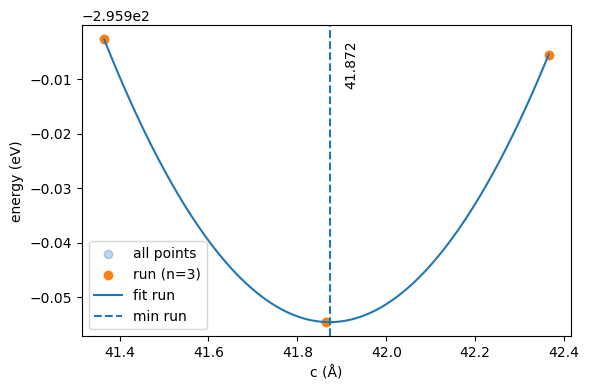

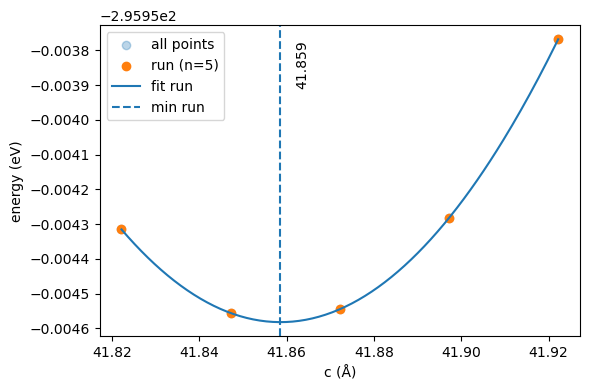

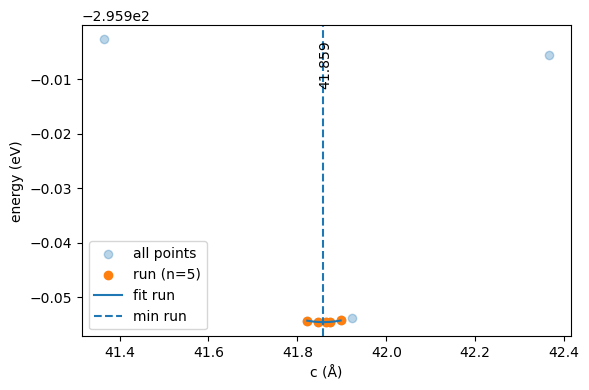

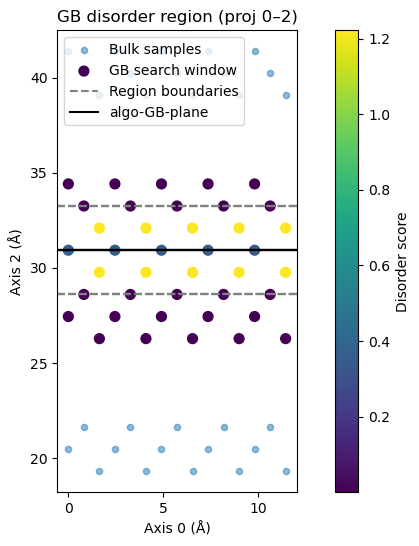

      Step     Time          Energy          fmax
BFGS:    0 21:49:29    -1755.813839        0.975448
BFGS:    1 21:49:31    -1755.911200        0.846555
BFGS:    2 21:49:34    -1756.270616        0.316306
BFGS:    3 21:49:36    -1756.286931        0.277440
BFGS:    4 21:49:39    -1756.347009        0.131891
BFGS:    5 21:49:41    -1756.349713        0.134465
BFGS:    6 21:49:43    -1756.364334        0.151217
BFGS:    7 21:49:47    -1756.366795        0.166286
BFGS:    8 21:49:48    -1756.374034        0.219394
BFGS:    9 21:49:49    -1756.381384        0.276290
BFGS:   10 21:49:52    -1756.391057        0.340747
BFGS:   11 21:49:54    -1756.400459        0.381005
BFGS:   12 21:49:56    -1756.415651        0.425655
BFGS:   13 21:49:56    -1756.438590        0.472074
BFGS:   14 21:50:00    -1756.475770        0.552671
BFGS:   15 21:50:01    -1756.518662        0.692161
BFGS:   16 21:50:02    -1756.563683        1.037622
BFGS:   17 21:50:03    -1756.603064        0.952313
BFGS:   18 21:

{'eos__B': 1.088879431373059,
 'eos__volumes': [21.332292682904004,
  21.594572051010047,
  21.858992463340865,
  22.12556262332826,
  22.39429123440404,
  22.665187000000007,
  22.938258623547974,
  23.21351480847975,
  23.490964258227127,
  23.770615676221958,
  24.052477765896],
 'eos__energies': [-16.426852917139826,
  -16.445540896964737,
  -16.459242587401747,
  -16.468383524321585,
  -16.47336894721072,
  -16.474570704126037,
  -16.472319307811315,
  -16.466900656091752,
  -16.45855656778395,
  -16.447488114746893,
  -16.43386071411896],
 'gb_structure__original_GBcode_structure': MSONAtoms(symbols='Fe36', pbc=True, cell=[41.56525744, 2.44925628, 3.99961876]),
 'gb_length_optimiser__stage1_opt_struct': MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925628, 3.99961876, 41.87218287394057]),
 'gb_length_optimiser__stage1_opt_excvol': 0.15346269024184664,
 'gb_length_optimiser__stage1_opt_GBEnergy': -295.9545830066832,
 'gb_length_optimiser__stage2_opt_struct': NOT_DATA,
 'gb_length_

In [7]:
# 1. Prepare calculator and workflow
calc = TPCalculator("/root/github_dev/pyiron_workflow_atomistics_scratch/2025_04_29_FeGB_Segregation_Workflows/final_model/")
wf   = Workflow("gb_optimiser_whole", delete_existing_savefiles=True)

# 2. Build your base Fe structure
bulk_Fe = bulk("Fe", cubic=True, a=2.83)
bulk_Fe.rattle()

# 3. Attach the macro node to the workflow, capturing all outputs
wf.eos = eos_volume_scan(
    base_structure = bulk_Fe,
    calc           = calc,
    calc_kwargs = {"fmax": 0.01,
                   "max_steps": 10000,
                   "properties": ("energy", "forces", "stresses", "volume"),
                   "write_to_disk": True,
                   "output_dir": "gb_optimiser_whole/EOS"},
    axes           = ["x", "y", "z"],
    strain_range   = (-0.02, 0.02),
    num_points     = 11,

)
wf.a0 = get_equil_lat_param(wf.eos.outputs.v0)
wf.eq_bulk_struct = get_bulk_structure(name = "Fe",
                           cubic = True,
                           a = wf.a0)
@pwf.as_function_node("equil_volume_peratom")
def get_per_atom_equil_vol(total_volume, structure):
    per_atom_equil_vol = total_volume/len(structure)
    return per_atom_equil_vol

@pwf.as_function_node("equil_energy_peratom")
def get_per_atom_equil_energy(total_energy, structure):
    per_atom_equil_energy = total_energy/len(structure)
    return per_atom_equil_energy
    
wf.equil_energy = get_per_atom_equil_vol(wf.eos.outputs.e0, wf.eq_bulk_struct.outputs.equil_struct)
wf.equil_volume = get_per_atom_equil_vol(wf.eos.outputs.v0, wf.eq_bulk_struct.outputs.equil_struct)
wf.gb_structure = construct_GB_from_GBCode(
    axis=(1, 1, 1),
    basis="bcc",
    lattice_param=wf.a0,
    m=3,
    n=1,
    GB1=(-1, -1, 2),
    element="Fe",
    req_length_grain=15,
    grain_length_axis=0,
    arrange_ab_by_length=True,
    perform_equiv_check=False,
    merge_dist_tolerance=1.3,
    merge_mode="average",
    equil_volume=wf.equil_volume
)
from pyiron_workflow_atomistics.gb.optimiser import full_gb_length_optimization
wf.gb_length_optimiser = full_gb_length_optimization(
    gb_structure=wf.gb_structure.outputs.final_structure,
    calc=calc,
    calc_kwargs={
        "fmax": 0.01,
        "max_steps": 500,
        "properties": ("energy", "forces", "stresses", "volume"),
        "write_to_disk": False,
        "output_dir": "gb_optimiser_whole/GB_length_opt"
    },
    equil_bulk_volume=wf.equil_volume,
    equil_bulk_energy=wf.equil_energy,
    extensions_stage1=np.linspace(-0.2, 0.8, 3),
    extensions_stage2=np.linspace(-0.05, 0.05, 5),
    interpolate_min_n_points=5,
    gb_normal_axis="c"
)

from pyiron_workflow_atomistics.structure_manipulator.tools import add_vacuum
wf.gb_with_vacuum = add_vacuum(wf.gb_length_optimiser.outputs.gb_structure_final,
                               vacuum_length = 20,
                               axis = "c")
wf.gb_with_vacuum_rel =  calculate_structure_node(
                                        structure = wf.gb_with_vacuum,
                                        calc = calc,
                                        fmax = 0.01,
                                        max_steps = 10000,
                                        properties = ('energy', 'forces', 'stresses'),
                                        write_to_disk = False,
                                        output_dir = "gb_optimiser_whole/GB_rel_vacuum",
                                        initial_struct_path = 'initial_structure.xyz',
                                        initial_results_path = 'initial_results.json',
                                        traj_struct_path = 'trajectory.xyz',
                                        traj_results_path = 'trajectory_results.json',
                                        final_struct_path = 'final_structure.xyz',
                                        final_results_path = 'final_results.json'
                                        )
from pyiron_workflow_atomistics.structure_manipulator.tools import create_supercell_with_min_dimensions

wf.gb_seg_supercell = create_supercell_with_min_dimensions(wf.gb_with_vacuum_rel.outputs.atoms, 
                                                           min_dimensions=[6, 6, None])

from pyiron_workflow_atomistics.featurisers import distanceMatrixSiteFeaturiser, voronoiSiteFeaturiser
from pyiron_workflow_atomistics.gb.analysis import plot_GB_plane, find_GB_plane
wf.gb_plane_extractor = find_GB_plane(atoms = wf.gb_with_vacuum,
                                        featuriser = voronoiSiteFeaturiser,
                                        axis = "c",
                                        approx_frac = 0.5,
                                        tolerance = 5.0,
                                        bulk_offset = 10.0,
                                        slab_thickness = 2.0,
                                        featuriser_kwargs = {},
                                        n_bulk = 10,
                                        threshold_frac = 1.0
                                      )
wf.gb_plane_extractor_plot = plot_GB_plane(atoms = wf.gb_with_vacuum,
                                            res = wf.gb_plane_extractor.outputs.gb_plane_analysis_dict,
                                            projection=(0, 2),
                                            reps=(5, 1),
                                            figsize=(10, 6),
                                            bulk_color='C0',
                                            window_cmap='viridis',
                                            plane_linestyles=('--', '-'),
                                            axis=2,
                                            dpi=300,
                                            save_path = f"gb_optimiser_whole/pureGB_plane_identifier.jpg")

import os
@pwf.as_function_node("structure", "output_dir")
def create_seg_structure_and_output_dir(structure,
                                    defect_site,
                                    element,
                                    structure_basename, 
                                    parent_dir):
    seg_structure = structure.copy()
    seg_structure[defect_site].symbol = element
    structure_name = f"{structure_basename}_{element}_{defect_site}"
    output_dir = os.path.join(parent_dir, structure_name)
    return seg_structure, output_dir

from pyiron_workflow.api import for_node
wf.gb_seg_structure_generator = for_node(create_seg_structure_and_output_dir,
                                    structure = wf.gb_seg_supercell,
                                    iter_on = ("defect_site"),
                                    defect_site = wf.gb_plane_extractor.outputs.gb_plane_analysis_dict["extended_sel_indices"],
                                    structure_basename = "S3_RA110_S112",
                                    element="C",
                                    parent_dir = "gb_optimiser_whole/segregation_calcs")
@pwf.as_function_node
def get_df_col_as_list(df, col):
    output_list = df[col].to_list()
    return output_list
wf.gb_seg_structure_list = get_df_col_as_list(wf.gb_seg_structure_generator.outputs.df, "structure")
wf.gb_seg_structure_dirs = get_df_col_as_list(wf.gb_seg_structure_generator.outputs.df, "output_dir")
from pyiron_workflow_atomistics.gb.optimiser import fillin_default_calckwargs
wf.full_calc_kwargs = fillin_default_calckwargs(calc_kwargs = {"fmax": 0.01,
                                                                "max_steps": 1000,
                                                                "properties": ("energy", "forces", "stresses", "volume"),
                                                                "write_to_disk": False,
                                                                "output_dir": "gb_optimiser_whole/segregation_calcs"},
                                                default_values = None)


wf.gb_seg_calcs = for_node(calculate_structure_node,
                           #iter_on=("structure",),
                            zip_on = ("structure", "output_dir"),
                            structure = wf.gb_seg_structure_list,
                            output_dir = wf.gb_seg_structure_dirs,
                            # These args are hardcoded (should be exactly the same as calculate_structure_node excluding structure and output_dir above)
                            # because no unzipping of kwargs is possible in a macro
                            calc = calc,
                            fmax=wf.full_calc_kwargs.outputs.full_calc_kwargs2["fmax"],
                            max_steps=wf.full_calc_kwargs.outputs.full_calc_kwargs2["max_steps"],
                            properties=wf.full_calc_kwargs.outputs.full_calc_kwargs2["properties"],
                            write_to_disk=wf.full_calc_kwargs.outputs.full_calc_kwargs2["write_to_disk"],
                            initial_struct_path=wf.full_calc_kwargs.outputs.full_calc_kwargs2["initial_struct_path"],
                            initial_results_path=wf.full_calc_kwargs.outputs.full_calc_kwargs2["initial_results_path"],
                            traj_struct_path=wf.full_calc_kwargs.outputs.full_calc_kwargs2["traj_struct_path"],
                            traj_results_path=wf.full_calc_kwargs.outputs.full_calc_kwargs2["traj_results_path"],
                            final_struct_path=wf.full_calc_kwargs.outputs.full_calc_kwargs2["final_struct_path"],
                            final_results_path=wf.full_calc_kwargs.outputs.full_calc_kwargs2["final_results_path"],
                        )
wf.run()

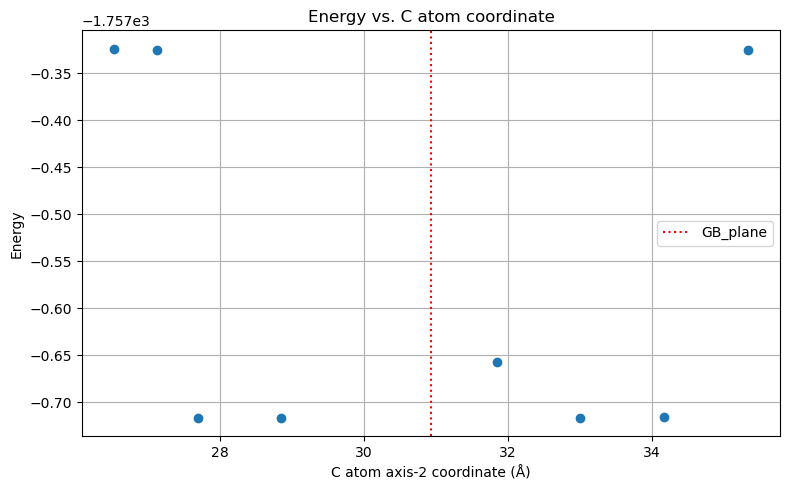

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Energy vs. C atom coordinate'}, xlabel='C atom axis-2 coordinate (Å)', ylabel='Energy'>)

In [8]:
import matplotlib.pyplot as plt

def plot_energy_vs_element_coord(
    df,
    element,
    output_file=None,
    gb_plane=None,
    axis=2
):
    """
    Plot energy vs. atomic coordinate for a given element.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with columns 'atoms' (ASE Atoms) and 'results' (dict with 'energy').
    element : str
        Chemical symbol to select (e.g. 'C', 'Fe').
    output_file : str or None
        File path to save the figure. If None, the figure is not saved.
    gb_plane : float or None
        Coordinate value at which to draw a vertical reference line (Å).
    axis : int
        Index of the Cartesian axis to use for coordinates (0=x,1=y,2=z).

    Returns
    -------
    fig, ax : matplotlib.figure.Figure, matplotlib.axes.Axes
    """
    coords = []
    energies = []

    for row in df.itertuples():
        atoms = row.atoms
        energy = row.results.get('energy')
        syms = atoms.get_chemical_symbols()
        pos = atoms.get_positions()

        for i, sym in enumerate(syms):
            if sym == element:
                coords.append(pos[i][axis])
                energies.append(energy)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.scatter(coords, energies, marker='o')
    ax.set_xlabel(f'{element} atom axis-{axis} coordinate (Å)')
    ax.set_ylabel('Energy')
    ax.set_title(f'Energy vs. {element} atom coordinate')

    if gb_plane is not None:
        ax.axvline(
            x=gb_plane,
            linestyle=':',
            color='r',
            label='GB_plane'
        )
        ax.legend()

    ax.grid(True)
    plt.tight_layout()

    if output_file:
        fig.savefig(output_file, dpi=300)

    plt.show()
    return fig, ax
plot_energy_vs_element_coord(df = wf.gb_seg_calcs.outputs.df.value,
                             element  = "C",
                             output_file="energy_vs_C_coord.png",
                             gb_plane= wf.gb_plane_extractor.outputs.gb_plane_analysis_dict.value["gb_cart"] )

In [44]:
#LAMMPS executable.

import os
import subprocess

from ase.build import bulk
from pyiron_lammps import parse_lammps_output_files, write_lammps_structure

lammps_input_script = """\
units metal
dimension 3
boundary p p p
atom_style atomic

read_data lammps_with_masses.data

pair_style grace
pair_coeff * * /cmmc/u/hmai/2025_04_29_FeGB_Segregation_Workflows/4_GPU_run1/seed/1/saved_model/ Fe

# per‐atom potential energy
compute eng all pe/atom

# dump every 10 steps: coords, forces, velocities, AND per‐atom energy
dump 1 all custom 10 dump.out id type xsu ysu zsu fx fy fz vx vy vz c_eng
dump_modify 1 sort id format line "%d %d %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g"

# global thermo output to log
thermo_style custom step temp pe etotal pxx pxy pxz pyy pyz pzz vol
thermo_modify format float %20.15g
thermo 10

min_style   cg
minimize    0 0.01 1000000 1000000
"""
from ase.io.lammpsdata import read_lammps_data, write_lammps_data
from pymatgen.core import Structure
from pymatgen.io.lammps.data import LammpsData
from pymatgen.io.ase import AseAtomsAdaptor


atoms = bulk("Fe") * [10,10,10]
atoms.rattle(0.3)
structure = AseAtomsAdaptor.get_structure(atoms)
lammps_data = LammpsData.from_structure(
    structure,
    atom_style="atomic",
)
os.makedirs(working_directory, exist_ok=True)
lammps_data.write_file("demo_pyiron_lammps/lammps_with_masses.data")
# 2) Assign chemical symbols so ASE knows which mass to use
#    Here all atoms are Fe:
atoms.set_chemical_symbols(['Fe'] * len(atoms))
# 3) Write out a new data file, sorted by type, with a Masses section
potential_elements = ["Fe"]
with open(os.path.join(working_directory, "lmp.in"), "w") as f:
    f.writelines(lammps_input_script)

command = "mpirun -np 40 --bind-to none /cmmc/ptmp/hmai/LAMMPS/lammps_grace/build/lmp -in lmp.in -log minimize.log"

output = subprocess.check_output(
    command,
    cwd=working_directory,
    shell=True,
    universal_newlines=True,
    env=os.environ.copy(),
)

output = parse_lammps_output_files(
    working_directory=working_directory,
    structure=atoms,
    potential_elements=potential_elements,
    units="metal",
    dump_h5_file_name="dump.h5",
    dump_out_file_name="dump.out",
    log_lammps_file_name="minimize.log",
)
output

2025-05-26 19:47:53.030543: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 19:47:53.030532: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 19:47:53.030551: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 19:47:53.035677: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machi

{'generic': {'eng': array([[-6.75575207, -6.72316516, -7.54244379, ..., -7.72358715,
          -7.61678979, -7.45744122],
         [-8.11920554, -8.14203334, -8.14581791, ..., -8.14692011,
          -8.14301978, -8.22608757],
         [-8.23136612, -8.22559122, -8.22854639, ..., -8.22281797,
          -8.23045368, -8.23411899],
         ...,
         [-8.22675499, -8.22704935, -8.22646648, ..., -8.22651629,
          -8.22698464, -8.22716539],
         [-8.22675528, -8.22705034, -8.22646711, ..., -8.22651417,
          -8.22698411, -8.22716571],
         [-8.22675747, -8.22705574, -8.22647044, ..., -8.22650307,
          -8.22698135, -8.22716716]]),
  'steps': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
         130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
         260]),
  'natoms': array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000.,

In [29]:
from ase.io.lammpsdata import read_lammps_data, write_lammps_data

# 1) Read your data file (this gives you types but no symbols)
# atoms = read_lammps_data(
#     filename='lammps.data',
#     style='atomic'
# )

# 2) Assign chemical symbols so ASE knows which mass to use
#    Here all atoms are Fe:
atoms.set_chemical_symbols(['Fe'] * len(atoms))

# 3) Write out a new data file, sorted by type, with a Masses section
write_lammps_data(
    file     = 'lammps_with_masses.data',
    atoms         = atoms,
    atom_style    = 'atomic',
    # sort_by_type  = True
)
